In [4]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
sys.path.append("/home/dashadower/git_repos/aria/")
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

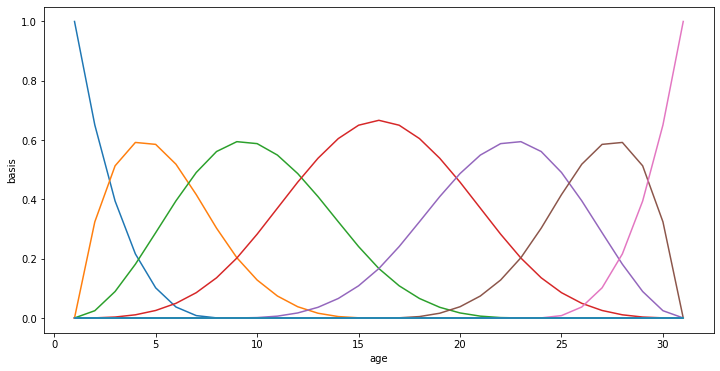

In [5]:
# knot 수에 따라 Bspline 파일 변

degree = 3
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [6]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/failure_count.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit_transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1)).flatten()
y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/age_pwr.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_pwr.csv"), usecols=["ship"])
engine_data = pd.read_csv(os.path.realpath("../data/engine_pwr.csv"), usecols=["engine"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/ship2engine_pwr.csv"), usecols=["engine"])
y_data.shape, age_data.shape, ship_data.shape, engine_data.shape, ship_engine_mapping_data.shape

((653, 1), (653, 1), (653, 1), (653, 1), (99, 1))

In [7]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = int(y_data.shape[0])
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

In [8]:
model_file = os.path.join('./stancode','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/hierarchical_model/stancode/layer3_nc_diffsd_parammubar


In [9]:
data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [10]:
layer3_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


In [11]:
layer3_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-1-euzkpnyr.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-2-a49rr1hp.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-3-u1rtqjyk.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-4-rfjrl76t.csv

Checking sampler transitions treedepth.
3923 of 4000 (98%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
76 of 4000 (1.9%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satis

"Processing csv files: /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-1-euzkpnyr.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-2-a49rr1hp.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-3-u1rtqjyk.csv, /tmp/tmp7ctfv8ge/layer3_nc_diffsd_parammubar-202008031732-4-rfjrl76t.csv\n\nChecking sampler transitions treedepth.\n3923 of 4000 (98%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n76 of 4000 (1.9%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satis

In [12]:
layer3_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-249.856000,0.115284,4.390170,-257.703000,-249.543000,-243.218000,1450.190,2.67789,1.000280
mu_a_bar,-0.011588,0.021430,1.001180,-1.690200,0.004545,1.646630,2182.670,4.03048,1.000410
mu_w_bar[1],-1.479210,0.017479,0.487956,-2.266730,-1.483530,-0.677969,779.380,1.43919,1.001500
mu_w_bar[2],0.557252,0.017285,0.550087,-0.352827,0.550666,1.470300,1012.860,1.87033,1.000240
mu_w_bar[3],-1.091790,0.017432,0.524578,-1.930430,-1.102130,-0.217625,905.621,1.67230,1.001930
...,...,...,...,...,...,...,...,...,...
y_hat[649],0.998437,0.014104,0.901621,-0.477130,0.986919,2.494430,4086.620,7.54627,0.999434
y_hat[650],1.020690,0.014714,0.927938,-0.479688,1.007480,2.539460,3976.980,7.34380,1.000880
y_hat[651],0.966936,0.014813,0.899244,-0.521218,0.957973,2.461440,3685.330,6.80525,0.999729


In [13]:
yhat = np.mean(layer3_fit.get_drawset(params=["y_hat"]), axis=0).values
yhat.shape

(653,)

In [14]:
lambda_ = np.array([0.21649144])
mean_ = np.array([4.96401329])
var_ = np.array([5.32670014])
scale_ = np.array([2.3079645])
n_samples_seen_ = 653
yhat = transformer.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [15]:
mean_squared_error(yhat, y_data["y"].values.flatten())

1184.2519675169033

In [16]:
layer3_fit.get_drawset(params=["y_hat"])

,y_hat.1,y_hat.2,y_hat.3,y_hat.4,y_hat.5,y_hat.6,y_hat.7,y_hat.8,y_hat.9,y_hat.10,...,y_hat.644,y_hat.645,y_hat.646,y_hat.647,y_hat.648,y_hat.649,y_hat.650,y_hat.651,y_hat.652,y_hat.653
0,-2.381250,-1.554020,-0.540471,-2.107900,-1.588970,0.414208,-0.819628,-0.485489,-0.967255,-0.377814,...,-0.128182,1.303700,1.658140,1.119830,1.288030,0.727764,1.654810,1.581290,0.536015,-1.410530
1,-2.318920,-1.121710,0.985371,-0.876219,-0.817839,0.963556,0.766756,-1.057340,-0.635005,-1.534870,...,1.270040,1.341380,1.846460,1.228800,3.268520,0.699663,-1.050100,-0.145891,1.621930,1.759770
2,-0.472281,-0.809558,-0.872053,-0.759973,-1.311880,-0.265703,1.304850,-1.281330,-0.208745,-0.262248,...,1.111360,0.225942,0.342735,0.968258,1.391430,1.042530,1.390910,0.920095,1.872690,2.265720
3,-1.887390,0.115129,-1.253310,-1.659030,-0.806964,0.226743,0.851500,-1.255660,0.138830,-1.251290,...,1.438240,-1.183490,-0.229279,0.289122,1.383040,0.021463,1.751070,0.801771,2.273620,0.296901
4,-0.739387,-1.371110,-0.503259,0.070526,0.040889,-0.875213,-0.396941,0.548991,-1.202900,-1.271300,...,2.255640,0.918456,1.731180,1.503160,3.352160,0.947696,3.503170,0.710856,-0.800927,1.088040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.597224,-1.483490,-0.811662,-1.088000,-0.549873,-0.844230,0.244730,-0.353543,0.114162,0.832349,...,0.082081,0.426544,2.244690,-0.098791,2.126660,1.207670,1.511630,0.354219,0.720562,1.058360
3996,-1.112800,-0.357018,-1.945370,-3.537990,-0.386341,0.095945,0.270413,-1.248170,-0.242977,-2.361190,...,1.983510,1.452600,2.906850,1.220950,0.806126,-1.542730,-0.144017,0.862874,0.253870,-0.058345
3997,-1.076280,-0.567941,-2.145570,0.142203,-1.206260,-0.965436,-0.748606,0.074440,-0.798139,0.641901,...,0.658941,1.949860,1.241050,-0.795612,-0.859931,1.801420,2.117030,2.822040,-0.685753,1.388620
3998,-2.374460,-0.007496,-1.677760,-1.131360,-0.712792,1.060720,-0.803420,-0.300671,-0.756272,-0.629657,...,1.081630,-0.119600,0.468205,0.094773,1.264150,0.291704,1.350390,1.279820,1.680990,1.945370


In [17]:
smape(yhat, y_data["y"].values.flatten())

1.9561752257445948

In [18]:
transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten()

array([  1.,   1.,   4.,  11.,   1.,  50.,  13.,   8.,   1.,   1.,   3.,
        45.,  35.,   2., 113.,  21.,  54.,  80.,  54.,  14.,  20.,  40.,
         7.,   5.,  27.,  17.,  25.,  56.,  76.,  13.,  29.,  33.,  56.,
        13.,  15.,  40.,  81.,  32.,  50.,   4.,  20.,  52.,   5.,  78.,
        31.,  25.,   1.,  13.,  68.,  47.,  62.,  99.,  11.,  20.,  30.,
        57.,  80.,  33.,  43.,  46.,  51.,  79.,  28.,  35.,  37.,  31.,
        17.,  83.,  69.,  71.,  69.,  22.,  41.,  43.,  22.,  37.,  44.,
        58.,   1.,  80.,  24.,  46.,  46.,  49.,  14.,  14.,  21.,  53.,
       100.,   3.,  12.,   8.,  31.,  82.,  73.,  65., 118.,   7.,  45.,
        22.,  74.,  97.,  38.,  61.,   4.,  76.,  42.,  22.,  17.,  38.,
        24.,  12.,  37.,   3.,   5.,  49.,  33.,   4.,   2.,  57.,   3.,
         3.,   6.,  13.,  28.,  52.,   9.,   2.,  11.,   9.,  22.,  17.,
         1.,  28.,  14.,  37.,  26.,   7.,  16.,   1.,  34.,  12.,   1.,
        33.,   8.,  39.,  32.,  25.,  17.,  19.,  2

In [21]:
yhat

array([ 6.0607325 ,  5.9435211 ,  6.21276422,  6.16796858,  5.79520366,
       17.05367459, 16.96072551, 17.00345961, 16.73132718, 16.99347003,
       16.70481805, 17.00304562, 16.89369971, 16.73577385, 16.93580374,
       16.6506719 , 16.60709796, 17.26507199, 16.31928822, 16.83301253,
       15.76897695, 28.60471018, 28.00544492, 28.36715652, 27.89070567,
       27.71868776, 28.68902772, 28.01386556, 28.39054629, 27.36429181,
       28.38475375, 28.11936758, 28.58160163, 28.77446409, 27.78231589,
       28.35550144, 27.38412525, 27.46447736, 27.79287665, 27.089432  ,
       35.76929589, 35.00233831, 35.18989595, 35.25847994, 35.50154341,
       35.5626552 , 35.78955292, 34.93455696, 35.12963733, 35.95265741,
       35.3206789 , 35.5022106 , 35.15155683, 35.72540084, 35.86273906,
       34.71322312, 34.60999541, 34.58786957, 37.68339284, 36.18137366,
       37.76478429, 36.97434453, 38.27788653, 38.71138741, 37.43572549,
       37.40915092, 37.87485899, 37.41241384, 37.58723739, 36.86